# 3.0.0 OD395 Prepare Dashboard

In [1]:
subject = 'OD395'
max_num_cells = 5000
view_top_var_genes = 250

In [2]:
from clustergrammer2 import net

import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

import himc_helper_functions_v0_12_3 as hf
hf.get_version()

import s3fs
import pyarrow.parquet as pq
fs = s3fs.S3FileSystem()
import umap
import random

df = {}

0.12.3 cleaning vdj code


In [3]:
def load_s3_parquet(bucket_path, filename, cols=None):

    if cols == None:
        df = pq.read_table(bucket_path + filename, use_pandas_metadata=True, filesystem=fs).to_pandas()
    else:
        df = pq.read_table(bucket_path + filename, use_pandas_metadata=True, filesystem=fs, columns=cols).to_pandas()
        
    return df

In [4]:
def make_umap_plot(df, cat_index, colors_dict, title, min_dist=1.0, n_neighbors=20, s=5.0, alpha=1.0, 
                   figsize=(10,10)):
    cols = df.columns.tolist()
    cats = [x[cat_index] for x in cols]
    list_colors = [colors_dict[x.split(': ')[1]] for x in cats]
    
    
    
    embedding = umap.UMAP(n_neighbors=n_neighbors, random_state=99,
                          min_dist=min_dist,
                          metric='correlation').fit_transform(df.transpose())
    
    df_umap = pd.DataFrame(data=embedding, columns=['x', 'y'])
    df_umap.plot(kind='scatter', x='x', y='y',  c=list_colors, alpha=alpha, s=s, figsize=figsize, 
                 title=title)
    
    return df_umap

In [5]:
cat_colors = net.load_json_to_dict('../data/processed_data/Consensus_GCT_Signatures/GCT_cell_type_colors.json')

In [6]:
base_path = 's3://himc-project-data/columbia_donor_citeseq/data/processed/merged_samples/'
df['meta_cell'] = load_s3_parquet(base_path, 'meta_cell_v2.parquet')
print(df['meta_cell'].shape)

df['meta_cell'] = df['meta_cell'][df['meta_cell']['Subject'] == subject]
df['meta_cell'] = df['meta_cell'][df['meta_cell']['GCT_Broad'] != 'Undefined']
df['meta_cell'] = df['meta_cell'][df['meta_cell']['GCT_Broad'] != 'non-immune']
df['meta_cell'] = df['meta_cell'][df['meta_cell']['GCT_Broad'] != 'Granulocytes']
print(df['meta_cell'].shape)
    
load_cells = sorted(df['meta_cell'].index.tolist())

(111141, 14)
(13268, 14)


### Load ADT Data

In [7]:
# base_path = 's3://himc-project-data/columbia_donor_citeseq/data/processed/merged_samples/'
# df['adt'] = load_s3_parquet(base_path, 'adt.parquet', cols=load_cells)

df['adt'] = pd.read_parquet('../data/processed/merged_samples/adt.parquet', columns=load_cells)
df['adt'].shape

(54, 13268)

### Load GEX Data

In [8]:
# base_path = 's3://himc-project-data/columbia_donor_citeseq/data/processed/merged_samples/'
# df['gex'] = load_s3_parquet(base_path, 'gex.parquet', cols=load_cells)

df['gex'] = pd.read_parquet('../data/processed/merged_samples/gex.parquet', columns=load_cells)
df['gex'].shape

df['gex'].shape

(33480, 13268)

### Drop Suspected Multiplets and Debris Based on ADTs

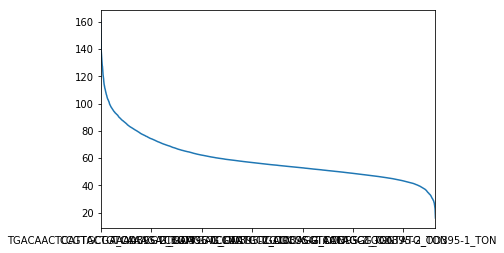

In [9]:
adt_sum = df['adt'].sum(axis=0)
adt_sum.sort_values(ascending=False).plot()

In [10]:
adt_sum = adt_sum[adt_sum < 100][adt_sum > 40]
keep_cells = adt_sum.index.tolist()

df['meta_cell'] = df['meta_cell'].loc[keep_cells]
df['adt'] = df['adt'][keep_cells]
df['gex'] = df['gex'][keep_cells]
df['meta_cell'].shape

(12229, 14)

### Drop Suspected Multiplets and Debris based on GEX

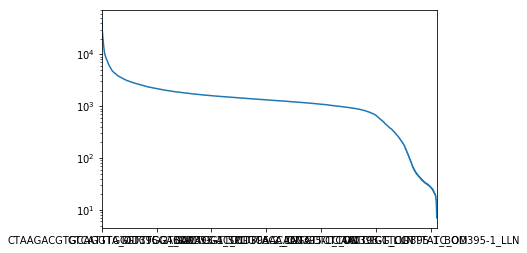

In [11]:
gex_sum = df['gex'].sum(axis=0)
gex_sum.sort_values(ascending=False).plot(logy=True)

In [12]:
gex_sum = gex_sum[gex_sum < 10000][gex_sum > 10]
keep_cells = gex_sum.index.tolist()

df['meta_cell'] = df['meta_cell'].loc[keep_cells]

### Run Additional Subsampling

In [13]:
if max_num_cells != 'N.A.':
    df['meta_cell'] = df['meta_cell'].sample(max_num_cells, random_state=99)
    print(df['meta_cell'].shape)

(5000, 14)


In [19]:
keep_cells = df['meta_cell'].index.tolist()
df['adt'] = df['adt'][keep_cells]
df['gex'] = df['gex'][keep_cells]
print(df['adt'].shape, df['gex'].shape)
df['meta_cell'].shape

(54, 5000) (33480, 5000)


(5000, 14)

In [20]:
df['meta_cell']['GCT_Broad'].value_counts()

T-cell        2233
B-cells       1544
Mono-mac       811
NK-cells       354
DC              36
Basophils       15
Mast_cells       6
pDCs             1
Name: GCT_Broad, dtype: int64

### Add Categories

In [21]:
add_cat_list = ['GCT_Narrow', 'Tissue', 'UMI_Sum']
new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, 
                                 barcodes=df['meta_cell'].index.tolist(), df_meta=df['meta_cell'])
df['adt'].columns = new_cols
df['gex'].columns = new_cols

In [22]:
df['gex-umi'] = np.arcsinh(net.umi_norm(df['gex'])/5)

In [23]:
df['gex-count'] = deepcopy(df['gex'])
df['gex-count'][df['gex-count'] > 1] = 1
ser_meas = df['gex-count'].sum(axis=1)
df['gex-count'] = ''

In [24]:
ser_meas.describe()

count    33480.000000
mean       112.564516
std        324.147950
min          0.000000
25%          0.000000
50%          2.000000
75%         74.000000
max       4933.000000
dtype: float64

In [25]:
ser_meas = ser_meas/ser_meas.shape[0]
ser_meas.describe()

count    33480.000000
mean         0.003362
std          0.009682
min          0.000000
25%          0.000000
50%          0.000060
75%          0.002210
max          0.147342
dtype: float64

In [26]:
keep_genes = ser_meas[ser_meas >= 0.01].index.tolist()
len(keep_genes)

3137

In [27]:
df['gex'] = df['gex'].loc[keep_genes]
df['gex-umi'] = df['gex-umi'].loc[keep_genes]
df['gex-umi'].shape

(3137, 5000)

### GEX UMI-ASH

In [28]:
net.load_df(df['gex-umi'])
net.set_cat_colors(axis='col', cat_index=1, cat_title='GCT_Narrow', cat_colors=cat_colors)
net.filter_N_top(inst_rc='row', N_top=view_top_var_genes, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.load_df(net.export_df().round(2))
df_gex_norm = net.export_df()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "MALAT1", "ini": 250, "clust": 43, "rank": 248, "rankvar": 247,…

### Get Category Colors

In [29]:
ini_cat_colors = net.viz['cat_colors']['col']
cat_colors = {}
for cat_title in ini_cat_colors:
    inst_cats = ini_cat_colors[cat_title]
    for inst_cat in inst_cats:
        inst_color = inst_cats[inst_cat]
        cat_name = inst_cat.split(': ')[1]
        if cat_name not in cat_colors:
            cat_colors[cat_name] = inst_color

### UMAP GEX: GCT Narrow

/srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/

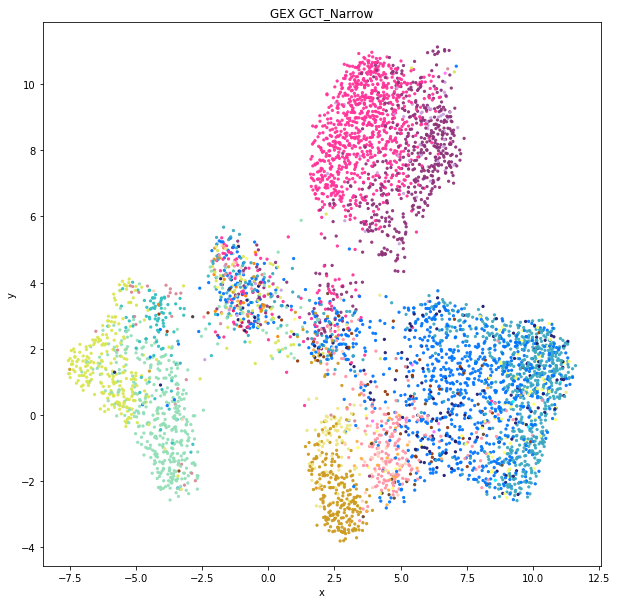

In [30]:
df_umap = make_umap_plot(df_gex_norm, 1, cat_colors, 'GEX GCT_Narrow', alpha=0.9, n_neighbors=20, min_dist=0.75)

### UMAP GEX: Tissue

/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


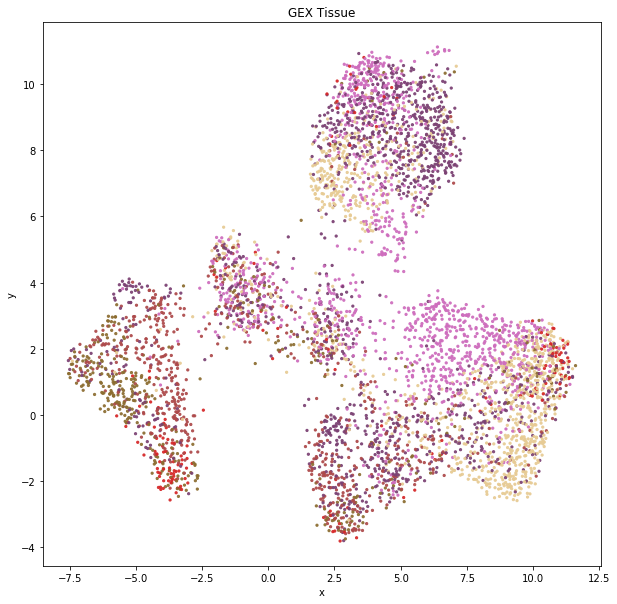

In [31]:
df_umap = make_umap_plot(df_gex_norm, 2, cat_colors, 'GEX Tissue', alpha=0.9, n_neighbors=20, min_dist=0.75)

In [32]:
df_umap_gex = deepcopy(df_umap)
df_umap_gex.columns = ['gex-umap-x', 'gex-umap-y']
df_umap_gex.index = [x[0] for x in df['gex'].columns.tolist()]
df_umap_gex.head()

,gex-umap-x,gex-umap-y
CCAGCGATCGTCTGCT_OD395-1_LLN,2.664588,7.442301
GAAGCAGGTCGTGGCT_OD395-1_SPL,-6.096565,1.913228
TCAGCAATCTGACCTC_OD395-1_SPL,3.213157,10.247568
GCTTCCAAGACATAAC_OD395-2_SPL,5.847332,8.148984
GAGGTGAGTATTACCG_OD395-2_LUN,0.466565,2.662177


# ADT

In [33]:
net.load_df(df['adt'])
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.load_df(net.export_df().round(2))
df_adt_norm = net.export_df()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD10", "ini": 54, "clust": 21, "rank": 1, "rankvar": 3, "group…

/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


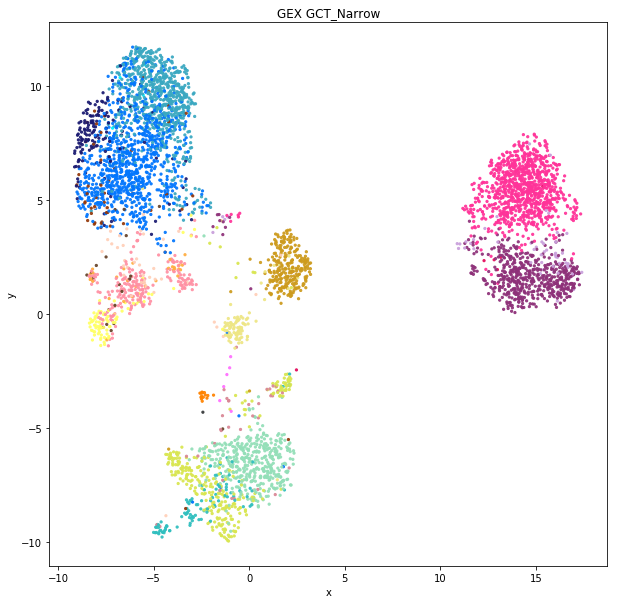

In [34]:
df_umap = make_umap_plot(df_adt_norm, 1, cat_colors, 'GEX GCT_Narrow', alpha=0.9, n_neighbors=20, min_dist=0.75)

/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


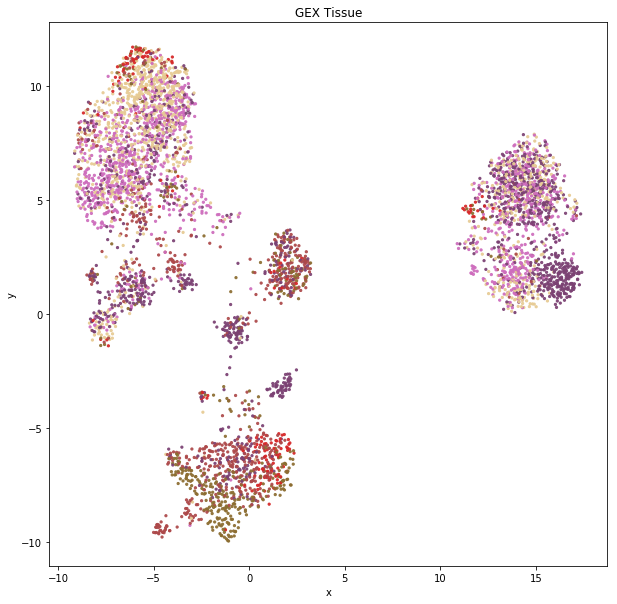

In [35]:
df_umap = make_umap_plot(df_adt_norm, 2, cat_colors, 'GEX Tissue', alpha=0.9, n_neighbors=20, min_dist=0.75)

In [36]:
df_umap_adt = deepcopy(df_umap)
df_umap_adt.columns = ['adt-umap-x', 'adt-umap-y']
df_umap_adt.index = [x[0] for x in df['adt'].columns.tolist()]
df_umap_adt.head()

,adt-umap-x,adt-umap-y
CCAGCGATCGTCTGCT_OD395-1_LLN,13.959531,6.965230
GAAGCAGGTCGTGGCT_OD395-1_SPL,-2.613368,-6.683358
TCAGCAATCTGACCTC_OD395-1_SPL,14.559320,4.894231
GCTTCCAAGACATAAC_OD395-2_SPL,16.669451,2.214815
GAGGTGAGTATTACCG_OD395-2_LUN,-1.921786,-5.642313


# Merge 

In [37]:
df_adt_stack = deepcopy(df_adt_norm)
df_gex_stack = deepcopy(df_gex_norm)
print(df_adt_stack.shape, df_gex_stack.shape)

(54, 5000) (250, 5000)


In [38]:
df_adt_stack.index = [(x + '_A', 'Type: ADT') for x in df_adt_stack.index.tolist()]
df_gex_stack.index = [(x , 'Type: GEX') for x in df_gex_stack.index.tolist()]

In [39]:
df_merge = pd.concat([df_adt_stack, df_gex_stack], axis=0)
df_merge.shape

(304, 5000)

In [40]:
cat_colors['ADT'] = '#A52A2A'
cat_colors['GEX'] = '#D3D3D3'

In [41]:
net.load_df(df_merge)
net.set_cat_colors(axis='row', cat_title='Type', cat_colors=cat_colors, cat_index=1)
net.clip(-5,5)
df_merge_norm = net.export_df()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD10_A", "ini": 304, "clust": 5, "rank": 190, "rankvar": 221, …

In [42]:
df_merge_export = deepcopy(df_merge_norm)
df_merge_export.columns = [x[0] for x in df_merge_export.columns.tolist()]
df_merge_export.index = [x[0] for x in df_merge_export.index.tolist()]
df_merge_export.to_parquet('../data/processed_data/OD395_Dashboard/merge_data.parquet')

In [43]:
!mkdir -p ../data/processed_data/OD395_Dashboard/

In [44]:
net.save_dict_to_json(inst_dict=net.viz, filename='../data/processed_data/OD395_Dashboard/merge_viz.json', indent=False)

/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


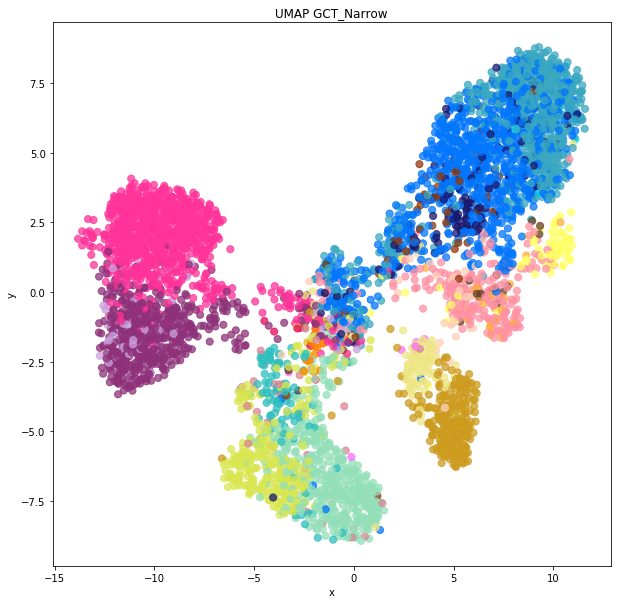

In [45]:
df_umap = make_umap_plot(df_merge_norm, cat_index=1, title='UMAP GCT_Narrow', colors_dict=cat_colors, s=50, alpha=0.75)

/srv/conda/envs/saturn/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../srv/conda/envs/saturn/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


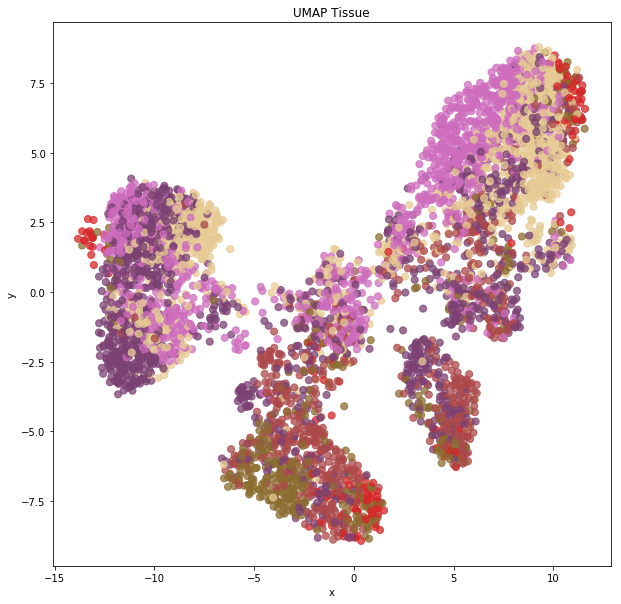

In [46]:
df_umap = make_umap_plot(df_merge_norm, cat_index=2, title='UMAP Tissue', colors_dict=cat_colors, s=50, alpha=0.75)

In [47]:
df_umap_merge = deepcopy(df_umap)
df_umap_merge.columns = ['merge-umap-x', 'merge-umap-y']
df_umap_merge.index = [x[0] for x in df_merge.columns.tolist()]
df_umap_merge.head()

,merge-umap-x,merge-umap-y
CCAGCGATCGTCTGCT_OD395-1_LLN,-8.223446,2.368487
GAAGCAGGTCGTGGCT_OD395-1_SPL,-4.756941,-5.674898
TCAGCAATCTGACCTC_OD395-1_SPL,-10.696349,3.068585
GCTTCCAAGACATAAC_OD395-2_SPL,-10.994710,-1.263441
GAGGTGAGTATTACCG_OD395-2_LUN,-1.635922,-4.495355


In [48]:
df_meta_new = pd.concat([df_umap_adt, df_umap_gex, df_umap_merge, df['meta_cell']], axis=1, sort=True)
df_meta_new.head()

,adt-umap-x,adt-umap-y,gex-umap-x,gex-umap-y,merge-umap-x,merge-umap-y,Sample,Subject,Tissue,Ini-Gated-Cell-Type,GCT_Broad,GCT_Narrow,UMI_Sum,Num_Meas_Genes,Hemoglobin_Expression,Red_Blood_Cell,Hemoglobin_Proportion,cell-per-bead-adt,num-meas-adt,cat-downsmple
AAACCTGAGAAAGTGG_OD395-2_SPL,-3.201653,7.992527,9.794993,1.078258,9.984531,6.201277,OD395-2,OD395,SPL,Naive__nonTregs,T-cell,T-cells_CD4_nonTregs_naive,1693.0,910.0,15.0,False,0.008860,singlet,10.0,NaN
AAACCTGAGCGCTTAT_OD395-2_TON,-6.179026,7.661500,6.078784,2.380895,4.709161,5.568419,OD395-2,OD395,TON,EM__nonTregs,T-cell,T-cells_CD4_nonTregs_memory,782.0,499.0,7.0,False,0.008951,singlet,6.0,NaN
AAACCTGAGTGAATTG_OD395-1_SPL,13.899639,5.701499,6.871429,8.222365,-10.532781,-0.674756,OD395-1,OD395,SPL,Naive_B_cells,B-cells,B-cells_naive,2352.0,1231.0,11.0,False,0.004677,singlet,5.0,NaN
AAACCTGCAACGATCT_OD395-2_SPL,-6.130447,1.650022,3.512142,0.651810,4.361988,0.702263,OD395-2,OD395,SPL,EM__CD8_T_cells,T-cell,T-cells_CD8_memory,380.0,239.0,6.0,False,0.015789,singlet,10.0,NaN
AAACCTGCACAGGCCT_OD395-2_LUN,-0.231736,-6.119434,-3.409588,0.915950,-1.223947,-5.421320,OD395-2,OD395,LUN,CD14_monocytes,Mono-mac,Monocytes_CD14,428.0,304.0,14.0,False,0.032710,singlet,12.0,NaN


In [49]:
df_meta_new.to_parquet('../data/processed_data/OD395_Dashboard/meta_cell.parquet')

### Upload to S3

In [50]:
!aws s3 cp --recursive ../data/processed_data/OD395_Dashboard/ s3://himc-project-data/columbia_donor_citeseq/data/processed/OD395_Dashboard/

upload: ../data/processed_data/OD395_Dashboard/GCT_cell_type_colors.json to s3://himc-project-data/columbia_donor_citeseq/data/processed/OD395_Dashboard/GCT_cell_type_colors.json
upload: ../data/processed_data/OD395_Dashboard/meta_cell.parquet to s3://himc-project-data/columbia_donor_citeseq/data/processed/OD395_Dashboard/meta_cell.parquet
upload: ../data/processed_data/OD395_Dashboard/merge_data.parquet to s3://himc-project-data/columbia_donor_citeseq/data/processed/OD395_Dashboard/merge_data.parquet
upload: ../data/processed_data/OD395_Dashboard/merge_viz.json to s3://himc-project-data/columbia_donor_citeseq/data/processed/OD395_Dashboard/merge_viz.json
